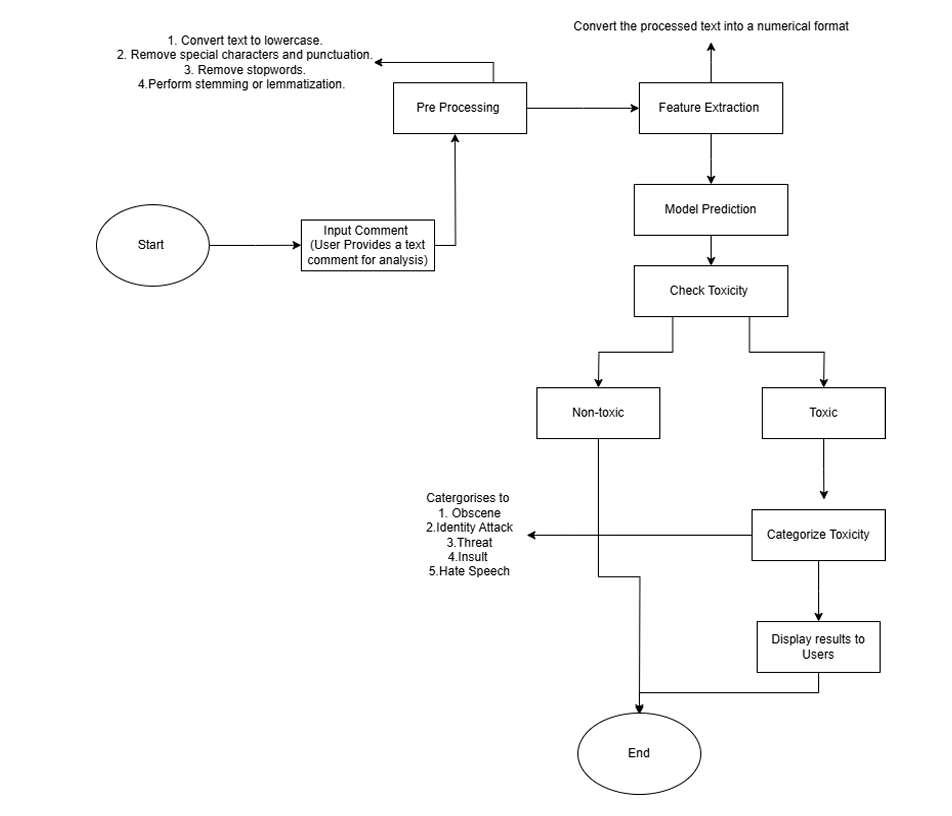

In [1]:
#!pip install pandas numpy tensorflow scikit-learn matplotlib
#!pip uninstall -y torch torchtext
#!pip install torch==2.1.0 torchtext==0.16.0


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
# Load training data
try:
    train_df = pd.read_csv('train.csv')
    print("Training data loaded successfully.")
except FileNotFoundError:
    print("Error: train.csv not found. Please check the file path.")

# Define target labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("Train Data Shape:", train_df.shape)
print("\nTrain Data Head:")
print(train_df.head())


Training data loaded successfully.
Train Data Shape: (159571, 8)

Train Data Head:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
print("Missing values in Train:")
print(train_df.isnull().sum())



Missing values in Train:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [6]:
# Information of the dataset
print("\nDataset Info:")
print(train_df.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count total occurrences of each label
label_counts = train_df[label_cols].sum().sort_values(ascending=False)

# Print label counts
print("\nLabel Counts in Training Data:")
print(label_counts)




Label Counts in Training Data:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


<ipython-input-8-1bd453b3e6c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


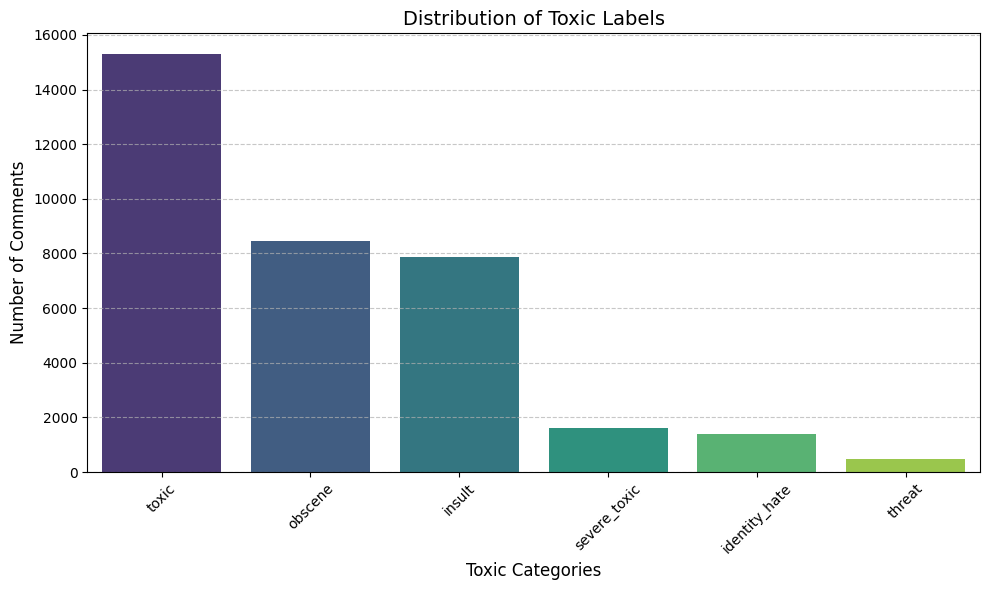

In [8]:
# Plot the label distribution
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Toxic Labels", fontsize=14)
plt.xlabel("Toxic Categories", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
# Count how many labels each comment has
train_df['multi_label_count'] = train_df[label_cols].sum(axis=1)

# Count of multi-label vs single-label
multi_label_comments = (train_df['multi_label_count'] > 1).sum()
single_label_comments = (train_df['multi_label_count'] == 1).sum()
no_label_comments = (train_df['multi_label_count'] == 0).sum()

# Print results
print(f" Comments with multiple labels: {multi_label_comments}")
print(f" Comments with a single label: {single_label_comments}")
print(f" Comments with no labels (which are clean comments): {no_label_comments}")


 Comments with multiple labels: 9865
 Comments with a single label: 6360
 Comments with no labels (which are clean comments): 143346


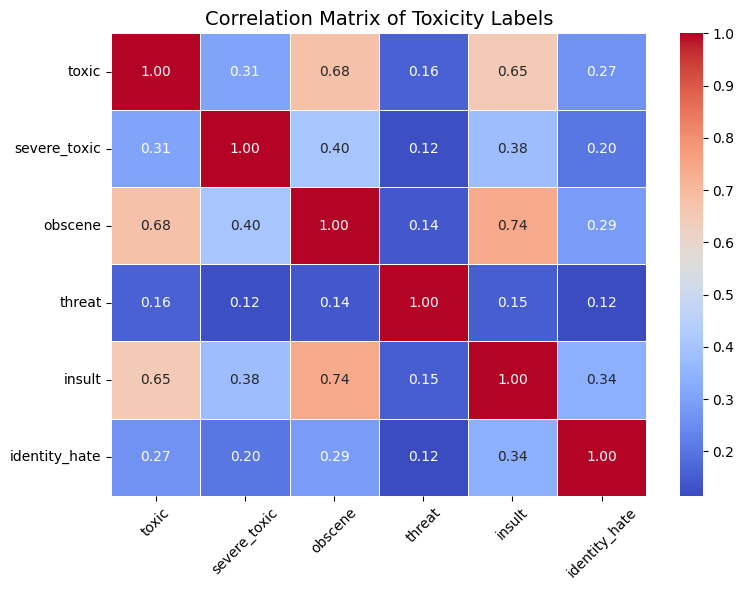

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = train_df[label_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Toxicity Labels", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


* Obscene & Insult (0.74): Strongest correlation — likely because many offensive comments contain both obscenities and insults.

* Toxic & Obscene (0.68) and Toxic & Insult (0.65): High correlation — toxic comments often include these traits.

* Threat has low correlation with other labels — it's a distinct class and often appears independently.

* Severe Toxic moderately correlates with Toxic (0.31) and Obscene (0.40), but occurs less frequently.



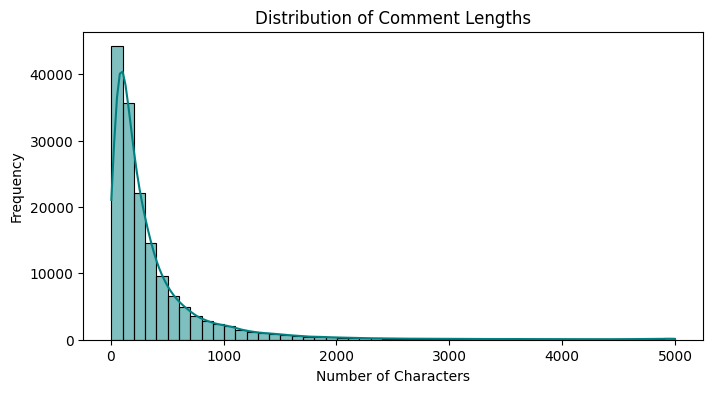

Average comment length: 394.07
95th percentile length: 1355.0


In [11]:
# comment length analysis to understand how long comments helps for choosing max sequence length for tokenization
train_df['comment_length'] = train_df['comment_text'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(train_df['comment_length'], bins=50, color='teal', kde=True)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

print(f"Average comment length: {train_df['comment_length'].mean():.2f}")
print(f"95th percentile length: {train_df['comment_length'].quantile(0.95)}")


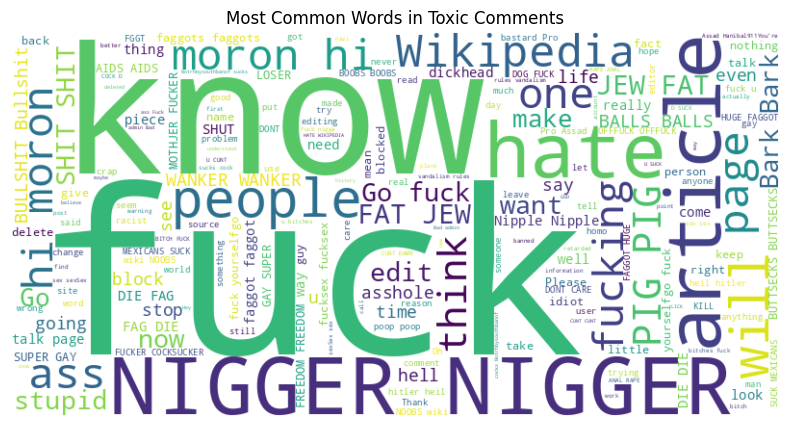

In [12]:
# Most Frequent Words

from wordcloud import WordCloud

toxic_comments = train_df[train_df['toxic'] == 1]['comment_text'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Toxic Comments")
plt.show()


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Filter toxic comments
toxic_comments = train_df[train_df['toxic'] == 1]['comment_text']

# Initialize CountVectorizer to extract words
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(toxic_comments)

# Sum and normalize frequencies
word_counts = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
word_frequencies = dict(zip(vocab, word_counts / word_counts.sum()))

# Top 20 words
words = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Normalized Frequencies'])
words = words.sort_values(by='Normalized Frequencies', ascending=False).head(20)
words['Normalized Frequencies'] *= 100  # convert to percentage

# Display
print("Top 20 words used in toxic comments:")
print(words.to_string(index=False))


Top 20 words used in toxic comments:
     Word  Normalized Frequencies
     fuck                2.633525
wikipedia                0.975046
     shit                0.960200
     like                0.931039
   nigger                0.874837
  fucking                0.871921
     suck                0.857606
      ass                0.779135
     hate                0.697484
      don                0.681048
     just                0.657719
      gay                0.593564
     know                0.583490
     page                0.569174
      die                0.551943
   faggot                0.534711
      fat                0.522251
   people                0.496536
    moron                0.493620
    bitch                0.473207


In [14]:
#Class Imbalance Ratio (Numerical Summary)
for label in label_cols:
    percent = 100 * train_df[label].sum() / len(train_df)
    print(f"{label:<15}: {percent:.2f}% positive examples")


toxic          : 9.58% positive examples
severe_toxic   : 1.00% positive examples
obscene        : 5.29% positive examples
threat         : 0.30% positive examples
insult         : 4.94% positive examples
identity_hate  : 0.88% positive examples


In [15]:
!pip install emoji

import emoji

# Function to check if a string contains any emoji
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

# Apply to dataset
train_df['has_emoji'] = train_df['comment_text'].apply(contains_emoji)

# Count how many comments contain emojis
emoji_count = train_df['has_emoji'].sum()
print(f"Number of comments with emojis: {emoji_count}")

# Optional: Show examples
print("\nExamples of comments with emojis:")
print(train_df[train_df['has_emoji'] == True]['comment_text'].head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.4 MB/s eta 0:00:00
Number of comments with emojis: 1198

Examples of comments with emojis:
126    Ahh, Hello Witzeman \n\n203.92.84.161  \nSymbo...
137    "\n\n Image:YourTransitAd.jpg \n\nI think I ma...
143    "P.S. It's not polite to talk to people behind...
189    "\n\nSorry to interrupt but I'm at 1200 edits ...
407    "\n\nI'm sorry if you will not like the answer...
Name: comment_text, dtype: object


In [16]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords
stpwds = stopwords.words('english')


In [18]:
import re
import string
import emoji
import spacy
from nltk.corpus import stopwords

# Load NLP model and stopwords
nlp = spacy.load("en_core_web_sm")
stpwds = stopwords.words('english')

# Custom punctuation cleanup
punc = string.punctuation
punc = punc.replace('#', '').replace('!', '').replace('?', '')  # keep those for possible model cues
punc = punc + "∞θ÷α•à−β∅³π‘₹´°£€\\×™√²—"

# Time zone tokens to remove
time_zone_abbreviations = [
    "UTC", "GMT", "EST", "CST", "PST", "MST",
    "EDT", "CDT", "PDT", "MDT", "CET", "EET",
    "WET", "AEST", "ACST", "AWST", "HST",
    "AKST", "IST", "JST", "KST", "NZST"
]


In [19]:
# Chat Word Dictionary (Slang Expansion)
chat_words = {
    "LOL": "laughing out loud", "BRB": "be right back", "OMG": "oh my god",
    "IMHO": "in my humble opinion", "FYI": "for your information",
    "IDK": "i don't know", "TTYL": "talk to you later", "SMH": "shaking my head",
    "BTW": "by the way", "JK": "just kidding", "ICYMI": "in case you missed it",
    "AFAIK": "as far as I know", "IRL": "in real life", "BFF": "best friends forever",
    "WTF": "what the fuck", "AFK": "away from keyboard", "IDC": "i don't care",
    "ROFL": "rolling on the floor laughing", "ILY": "i love you", "U": "you", "UR": "your"

}


In [20]:
# Define regex patterns
patterns = [
    r'\\[nrtbfv\\]',         # escape characters
    r'<.*?>',                # HTML tags
    r'https?://\S+|www\.\S+',# URLs
    r'\ufeff',               # BOM
    r'^[^a-zA-Z0-9]+$',      # non-alphanum tokens
    r'ｗｗｗ．\S+',           # full-width URLs
    r'[\uf700-\uf7ff]',      # Unicode private-use
    r'^[－—…]+$',            # special puncs
    r'[︵︶]',               # CJK parens
    r'\d+'                   # digits
]

# Final preprocessing function
def preprocess(text):
    # Apply regex filters
    for regex in patterns:
        text = re.sub(regex, '', text)

    # Remove/replace punctuation
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))

    # Remove time zones and expand chat words
    text = ' '.join(chat_words.get(word.upper(), word) for word in text.split() if word not in time_zone_abbreviations)

    # Convert to lowercase
    text = text.lower()

    # Demojize (convert emojis to text)
    text = emoji.demojize(text)

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Optional: Lemmatization (beneficial for classic models)
    doc = nlp(text)
    text = ' '.join(token.lemma_ for token in doc if token.lemma_ != '-PRON-')

    # Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [21]:
#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")

#train_df['clean_text'] = train_df['comment_text'].apply(preprocess)
#test_df['clean_text'] = test_df['comment_text'].apply(preprocess)

#train_df.to_csv("clean_train.csv", index=False)
#test_df.to_csv("clean_test.csv", index=False)


#train_df = pd.read_csv("clean_train.csv")
#test_df = pd.read_csv("clean_test.csv")


In [31]:
# Load preprocessed data from saved CSVs
train_df = pd.read_csv("clean_train.csv")


In [32]:
print(train_df.columns.tolist())


['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean_text', 'label']


**Tokenizer and Vocabulary**

In [35]:
# Verify presence of 'clean_text'
assert 'clean_text' in train_df.columns, "'clean_text' column not found in train_df"
# Ensure 'clean_text' column is string type and drop NaNs if any
train_df['clean_text'] = train_df['clean_text'].astype(str).fillna("")


In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# === Tokenizer Parameters ===
VOCAB_SIZE = 30000
OOV_TOKEN = "<OOV>"
MAX_LEN = 100

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_df['clean_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train_df[label_cols].values


In [37]:
from sklearn.utils import resample

# Wrap raw X and y into DataFrame for resampling
train_data = pd.DataFrame({'comment': train_df['clean_text']})
for i, col in enumerate(label_cols):
    train_data[col] = train_df[col]

# Get max class count
max_size = int(train_data[label_cols].sum().max())

# Upsample each class
upsampled = []
for label in label_cols:
    class_data = train_data[train_data[label] == 1]
    upsampled_data = resample(class_data, replace=True, n_samples=max_size, random_state=42)
    upsampled.append(upsampled_data)

# Merge upsampled data
train_upsampled = pd.concat(upsampled).sample(frac=1, random_state=42)

# Final balanced train set

X_train_text = train_upsampled['comment'].values
y_train = train_upsampled[label_cols].values

# Re-tokenize and pad
train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')


In [38]:
# === Updated training arrays ===
X_train = train_upsampled['comment'].values
y_train = train_upsampled[label_cols].values

print(f"\nUpsampled Train size: {len(X_train)} (per class: {max_size})")


Upsampled Train size: 91764 (per class: 15294)


In [39]:
# Re-tokenize and pad the upsampled balanced dataset
train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# X_train now holds tokenized padded input for upsampled comments
# y_train is already updated and balanced
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (91764, 100)
y_train shape: (91764, 6)


In [40]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


LSTM

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, hamming_loss, roc_auc_score, f1_score
import tensorflow.keras.backend as K
import numpy as np

# === Step 1: Define Focal Loss ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return loss_fn

# === Step 2: Define Model ===
def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
        LSTM(64),
        Dropout(0.3),
        Dense(6, activation='sigmoid')
    ])
    model.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer=Adam(1e-4), metrics=['accuracy'])
    return model

# === Step 3: Train Model ===
model_lstm = create_lstm_model()
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_tr, y_tr,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.9426 - loss: 0.3411 - val_accuracy: 0.9420 - val_loss: 0.3058
Epoch 2/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9286 - loss: 0.2865 - val_accuracy: 0.8964 - val_loss: 0.2019
Epoch 3/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8548 - loss: 0.1973 - val_accuracy: 0.8792 - val_loss: 0.1723
Epoch 4/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.8383 - loss: 0.1652 - val_accuracy: 0.8316 - val_loss: 0.1856
Epoch 5/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8321 - loss: 0.1474 - val_accuracy: 0.8729 - val_loss: 0.1365
Epoch 6/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8198 - loss: 0.1333 - val_accuracy: 0.8892 - val_loss: 0.1232
Epoch 7/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8423 - loss: 0.1299 - val_accuracy: 0.9160 - val_loss: 0.1507
Epoch 8/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8659 -

In [42]:
# Predict on validation set
y_pred_lstm = model_lstm.predict(X_val)

# Threshold optimization
best_thresholds = []
for i in range(y_val.shape[1]):
    best_f1, best_t = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        score = f1_score(y_val[:, i], (y_pred_lstm[:, i] > t).astype(int))
        if score > best_f1:
            best_f1 = score
            best_t = t
    best_thresholds.append(best_t)

print("🔧 Optimized thresholds:", np.round(best_thresholds, 2))

# Apply thresholds
y_pred_binary_lstm = np.array([
    [1 if p > t else 0 for p, t in zip(row, best_thresholds)]
    for row in y_pred_lstm
])

# Evaluation
print("\n📊 LSTM Classification Report:")
print(classification_report(y_val, y_pred_binary_lstm, target_names=label_cols, zero_division=0))
print("Hamming Loss:", hamming_loss(y_val, y_pred_binary_lstm))
try:
    print("ROC-AUC Score:", roc_auc_score(y_val, y_pred_lstm))
except:
    print("ROC-AUC could not be computed.")


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
🔧 Optimized thresholds: [0.43 0.39 0.36 0.51 0.39 0.44]

📊 LSTM Classification Report:
               precision    recall  f1-score   support

        toxic       0.98      0.99      0.99      8707
 severe_toxic       0.89      0.90      0.89      2925
      obscene       0.97      0.94      0.96      7091
       threat       0.97      1.00      0.98      1927
       insult       0.91      0.89      0.90      7037
identity_hate       0.96      0.94      0.95      2747

    micro avg       0.95      0.94      0.95     30434
    macro avg       0.95      0.94      0.95     30434
 weighted avg       0.95      0.94      0.95     30434
  samples avg       0.93      0.92      0.92     30434

Hamming Loss: 0.057589626239511825
ROC-AUC Score: 0.968540775457012




*   High performance across all labels

* Balanced precision and recall (no bias toward positives or negatives)

* Low hamming loss (fewer misclassifications)

* Very high ROC-AUC → excellent discrimination between classes



In [44]:
# Pretty print without np.int64 wrapping
print("Predicted Labels:")
for label, value in zip(label_cols, y_pred_binary_lstm[example_idx]):
    print(f"{label}: {'Yes' if value else 'No'}")


Predicted Labels:
toxic: Yes
severe_toxic: Yes
obscene: Yes
threat: Yes
insult: Yes
identity_hate: Yes


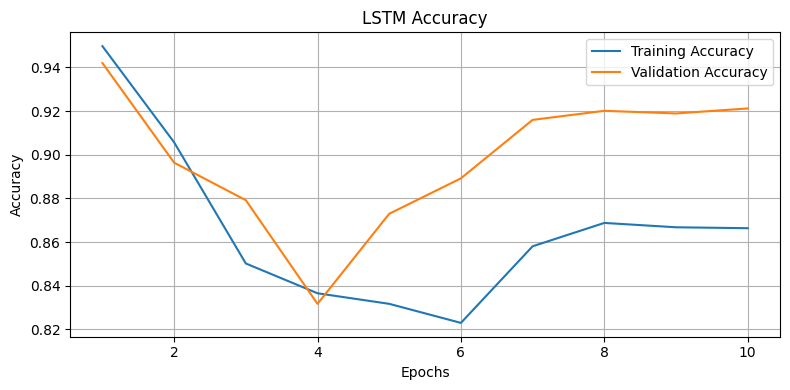

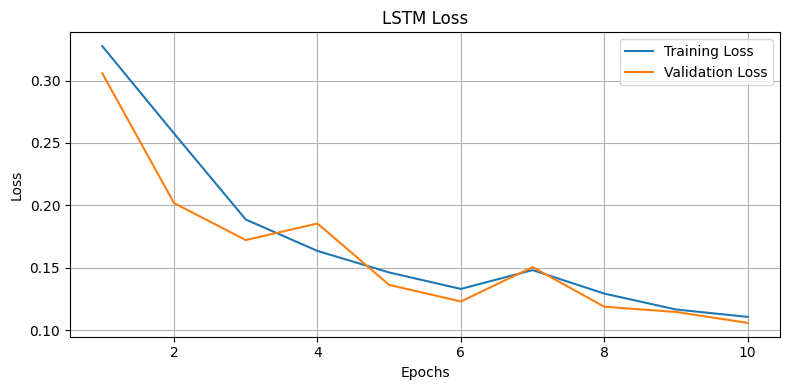

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="LSTM"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_training_history(history_lstm, model_name="LSTM")


Bi-LSTM

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, roc_auc_score
import tensorflow.keras.backend as K
import numpy as np

# === Step 1: Define Focal Loss ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        return K.mean(K.sum(weight * cross_entropy, axis=-1))
    return loss_fn

# === Step 2: Define Improved BiLSTM Model ===
def create_bilstm_model(input_dim, output_dim=128, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(6, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(gamma=2., alpha=0.25),
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

# === Step 3: Instantiate and Train ===
model_bilstm = create_bilstm_model(input_dim=VOCAB_SIZE)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history_bilstm = model_bilstm.fit(
    X_tr, y_tr,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.8871 - loss: 0.2978 - val_accuracy: 0.8330 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 2/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.7661 - loss: 0.1681 - val_accuracy: 0.8004 - val_loss: 0.1389 - learning_rate: 1.0000e-04
Epoch 3/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.7148 - loss: 0.1340 - val_accuracy: 0.7833 - val_loss: 0.1145 - learning_rate: 1.0000e-04
Epoch 4/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.6897 - loss: 0.1114 - val_accuracy: 0.7215 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 5/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6623 - loss: 0.0935 - val_accuracy: 0.6539 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 6/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.6682 - loss: 0.0776 - val_accuracy: 0.7610 - val_loss: 0.0749 - learning_rate: 1.0000e-04
Epoch 7/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/

In [52]:
# === Predict on Validation Set ===
y_pred_bilstm = model_bilstm.predict(X_val)

# === Threshold Tuning ===
best_thresholds = []
for i in range(y_val.shape[1]):
    best_f1, best_t = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        pred_bin = (y_pred_bilstm[:, i] > t).astype(int)
        score = f1_score(y_val[:, i], pred_bin, zero_division=0)
        if score > best_f1:
            best_f1, best_t = score, t
    best_thresholds.append(best_t)

print("🔧 Optimized thresholds:", np.round(best_thresholds, 2))

# === Apply Optimized Thresholds ===
y_pred_binary_bilstm = np.array([
    [1 if p > t else 0 for p, t in zip(row, best_thresholds)]
    for row in y_pred_bilstm
])


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
🔧 Optimized thresholds: [0.31 0.33 0.42 0.4  0.38 0.35]


In [57]:
# === Classification Report & Metrics ===
print("\nBiLSTM Classification Report:")
print(classification_report(y_val, y_pred_binary_bilstm, target_names=label_cols, zero_division=0))
print("Hamming Loss:", hamming_loss(y_val, y_pred_binary_bilstm))

try:
    print("ROC-AUC Score:", roc_auc_score(y_val, y_pred_bilstm))
except Exception as e:
    print("ROC-AUC could not be computed:", e)

# Exact Match Accuracy (strict)
exact_match_accuracy = accuracy_score(y_val, y_pred_binary_bilstm)
print(f"ch Accuracy: {exact_match_accuracy:.4f}")



BiLSTM Classification Report:
               precision    recall  f1-score   support

        toxic       0.99      1.00      0.99      8707
 severe_toxic       0.92      0.96      0.94      2925
      obscene       0.98      0.98      0.98      7091
       threat       0.99      1.00      0.99      1927
       insult       0.96      0.98      0.97      7037
identity_hate       0.97      0.98      0.97      2747

    micro avg       0.97      0.98      0.98     30434
    macro avg       0.97      0.98      0.97     30434
 weighted avg       0.97      0.98      0.98     30434
  samples avg       0.96      0.98      0.97     30434

Hamming Loss: 0.02538956085866841
ROC-AUC Score: 0.9905130863439665
ch Accuracy: 0.8773


hreat, severe_toxic, identity_hate works well for Bi-LSTM.
No major class skew or bias – high precision and recall across the board.

BiLSTM architecture is outperforming standard LSTM, likely due to:

* Better context modeling (past + future)

* Class balancing + threshold tuning



In [58]:
non_toxic_indices = np.where(y_val.sum(axis=1) == 0)[0]
false_positives = sum(y_pred_binary_bilstm[non_toxic_indices].sum(axis=1) > 0)

print(f"🚨 Non-toxic comments falsely predicted as toxic: {false_positives}")


🚨 Non-toxic comments falsely predicted as toxic: 0


In [59]:
# Get number of toxic samples in validation
is_toxic = (y_val.sum(axis=1) > 0)
toxic_total = np.sum(is_toxic)

# Get number of correctly predicted toxic (i.e., any predicted label is 1)
predicted_toxic = (y_pred_binary_bilstm.sum(axis=1) > 0)

# How many toxic comments were detected?
toxic_caught = np.sum(is_toxic & predicted_toxic)

print(f" Toxic samples in validation: {toxic_total}")
print(f" Toxic samples predicted as toxic: {toxic_caught}")
print(f" Recall on toxic vs non-toxic: {toxic_caught/toxic_total:.2%}")


✅ Toxic samples in validation: 9177
🎯 Toxic samples predicted as toxic: 9156
🔁 Recall on toxic vs non-toxic: 99.77%


In [60]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Focal Loss Function ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        return K.mean(K.sum(weight * cross_entropy, axis=-1))
    return loss_fn


In [61]:
def create_bigru_model(input_dim, output_dim=128, gru_units=128, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=MAX_LEN),
        Bidirectional(GRU(gru_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(6, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(gamma=2., alpha=0.25),
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model


In [62]:
model_bigru = create_bigru_model(input_dim=VOCAB_SIZE)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history_bigru = model_bigru.fit(
    X_tr, y_tr,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8888 - loss: 0.3042 - val_accuracy: 0.8217 - val_loss: 0.1918 - learning_rate: 1.0000e-04
Epoch 2/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7597 - loss: 0.1774 - val_accuracy: 0.7351 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 3/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.6694 - loss: 0.1379 - val_accuracy: 0.6228 - val_loss: 0.1214 - learning_rate: 1.0000e-04
Epoch 4/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.6031 - loss: 0.1188 - val_accuracy: 0.6488 - val_loss: 0.1079 - learning_rate: 1.0000e-04
Epoch 5/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.5784 - loss: 0.1028 - val_accuracy: 0.5917 - val_loss: 0.1007 - learning_rate: 1.0000e-04
Epoch 6/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.5439 - loss: 0.0884 - val_accuracy: 0.5572 - val_loss: 0.0834 - learning_rate: 1.0000e-04
Epoch 7/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/

In [63]:
y_pred_bigru = model_bigru.predict(X_val)

best_thresholds = []
for i in range(y_val.shape[1]):
    best_f1, best_t = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        score = f1_score(y_val[:, i], (y_pred_bigru[:, i] > t).astype(int), zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_t = t
    best_thresholds.append(best_t)

print("🔧 Optimized Thresholds:", np.round(best_thresholds, 2))

y_pred_binary_bigru = np.array([
    [1 if p > t else 0 for p, t in zip(row, best_thresholds)]
    for row in y_pred_bigru
])


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
🔧 Optimized Thresholds: [0.49 0.41 0.4  0.42 0.35 0.38]


In [65]:
print("\n BiGRU Classification Report:")
print(classification_report(y_val, y_pred_binary_bigru, target_names=label_cols, zero_division=0))
print("Hamming Loss:", hamming_loss(y_val, y_pred_binary_bigru))

try:
    print("ROC-AUC Score:", roc_auc_score(y_val, y_pred_bigru))
except:
    print("ROC-AUC could not be computed.")

exact_match_accuracy = accuracy_score(y_val, y_pred_binary_bigru)
print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")



 BiGRU Classification Report:
               precision    recall  f1-score   support

        toxic       0.99      0.99      0.99      8707
 severe_toxic       0.92      0.96      0.94      2925
      obscene       0.97      0.98      0.98      7091
       threat       0.99      1.00      0.99      1927
       insult       0.95      0.97      0.96      7037
identity_hate       0.97      0.97      0.97      2747

    micro avg       0.97      0.98      0.97     30434
    macro avg       0.96      0.98      0.97     30434
 weighted avg       0.97      0.98      0.97     30434
  samples avg       0.96      0.97      0.96     30434

Hamming Loss: 0.029675638371290544
ROC-AUC Score: 0.989374676205197
Exact Match Accuracy: 0.8601


In [67]:
# Function to decode token IDs back into readable words
def decode_comment(token_ids, tokenizer):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_index.get(i, '') for i in token_ids if i != 0])

example_idx = 0
decoded_comment = decode_comment(X_val[example_idx], tokenizer)

print("\n🔍 Original Comment:")
print(decoded_comment)

print("\nTrue Labels:")
print(dict(zip(label_cols, y_val[example_idx])))

print("\nPredicted Labels:")
print(dict(zip(label_cols, y_pred_binary_bigru[example_idx])))



🔍 Original Comment:
fuck all <OOV> nation qamishli belong to <OOV> and we will fuck all <OOV> people if they will say no

True Labels:
{'toxic': np.int64(1), 'severe_toxic': np.int64(1), 'obscene': np.int64(1), 'threat': np.int64(1), 'insult': np.int64(1), 'identity_hate': np.int64(1)}

Predicted Labels:
{'toxic': np.int64(1), 'severe_toxic': np.int64(1), 'obscene': np.int64(1), 'threat': np.int64(1), 'insult': np.int64(1), 'identity_hate': np.int64(1)}


Hybrid Model

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, hamming_loss, f1_score, accuracy_score
import tensorflow.keras.backend as K
import numpy as np

#  Focal Loss Function ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        return K.mean(K.sum(weight * cross_entropy, axis=-1))
    return loss_fn

# Define the CNN + LSTM Model
def create_cnn_lstm_model(input_dim, output_dim=128, filters=128, kernel_size=3, lstm_units=128):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=MAX_LEN),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units),
        Dropout(0.5),
        Dense(6, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(gamma=2., alpha=0.25),
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model


In [69]:
model_cnn_lstm = create_cnn_lstm_model(input_dim=VOCAB_SIZE)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.5, verbose=1)

history_cnn_lstm = model_cnn_lstm.fit(
    X_tr, y_tr,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2581/2581 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9247 - loss: 0.3236 - val_accuracy: 0.9132 - val_loss: 0.1968 - learning_rate: 1.0000e-04
Epoch 2/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8300 - loss: 0.1924 - val_accuracy: 0.8265 - val_loss: 0.1485 - learning_rate: 1.0000e-04
Epoch 3/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8006 - loss: 0.1371 - val_accuracy: 0.7872 - val_loss: 0.1013 - learning_rate: 1.0000e-04
Epoch 4/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.7568 - loss: 0.0929 - val_accuracy: 0.7939 - val_loss: 0.0905 - learning_rate: 1.0000e-04
Epoch 5/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7614 - loss: 0.0735 - val_accuracy: 0.8194 - val_loss: 0.0710 - learning_rate: 1.0000e-04
Epoch 6/10
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.7842 - loss: 0.0569 - val_accuracy: 0.8210 - val_loss: 0.0625 - learning_rate: 1.0000e-04
Epoch 7/10
2578/2581 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

In [70]:
# Predict on validation set
y_pred_cnn_lstm = model_cnn_lstm.predict(X_val)

# Optimize thresholds for each label
best_thresholds = []
for i in range(y_val.shape[1]):
    best_f1, best_t = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        score = f1_score(y_val[:, i], (y_pred_cnn_lstm[:, i] > t).astype(int), zero_division=0)
        if score > best_f1:
            best_f1, best_t = score, t
    best_thresholds.append(best_t)

print(" Optimized Thresholds:", np.round(best_thresholds, 2))

# Apply thresholds
y_pred_binary_cnn_lstm = np.array([
    [1 if p > t else 0 for p, t in zip(row, best_thresholds)]
    for row in y_pred_cnn_lstm
])


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
🔧 Optimized Thresholds: [0.36 0.41 0.43 0.29 0.37 0.31]


In [72]:
print("\n CNN+LSTM Classification Report:")
print(classification_report(y_val, y_pred_binary_cnn_lstm, target_names=label_cols, zero_division=0))

print("Hamming Loss:", hamming_loss(y_val, y_pred_binary_cnn_lstm))

exact_match_accuracy = accuracy_score(y_val, y_pred_binary_cnn_lstm)
print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")



 CNN+LSTM Classification Report:
               precision    recall  f1-score   support

        toxic       1.00      1.00      1.00      8707
 severe_toxic       0.98      0.99      0.98      2925
      obscene       0.98      0.99      0.99      7091
       threat       1.00      1.00      1.00      1927
       insult       0.97      0.98      0.98      7037
identity_hate       0.99      1.00      0.99      2747

    micro avg       0.99      0.99      0.99     30434
    macro avg       0.99      0.99      0.99     30434
 weighted avg       0.99      0.99      0.99     30434
  samples avg       0.98      0.99      0.98     30434

Hamming Loss: 0.012858232537866405
Exact Match Accuracy: 0.9401


* CNN handles local patterns (e.g., swear
words, phrases)

* LSTM captures sequential context (e.g., how toxicity builds in sentences)



In [77]:
# Example after evaluating a model
results = {}

results['LSTM'] = {
    'accuracy': accuracy_score(y_val, y_pred_binary_lstm),
    'hamming_loss': hamming_loss(y_val, y_pred_binary_lstm),
}

results['BiLSTM'] = {
    'accuracy': accuracy_score(y_val, y_pred_binary_bilstm),
    'hamming_loss': hamming_loss(y_val, y_pred_binary_bilstm),
}

results['GRU'] = {
    'accuracy': accuracy_score(y_val, y_pred_binary_bigru),
    'hamming_loss': hamming_loss(y_val, y_pred_binary_bigru),
}

results['CNN+LSTM'] = {
    'accuracy': accuracy_score(y_val, y_pred_binary_cnn_lstm),
    'hamming_loss': hamming_loss(y_val, y_pred_binary_cnn_lstm),
}


In [78]:
import pandas as pd

# Create comparison DataFrame
results_df = pd.DataFrame(results).T  # transpose for better formatting

# Format as percentage and 4 decimals
results_df['accuracy'] = results_df['accuracy'].apply(lambda x: f"{x*100:.2f}%")
results_df['hamming_loss'] = results_df['hamming_loss'].apply(lambda x: f"{x:.4f}")

# Display
print("Model Comparison Summary:")
display(results_df)


Model Comparison Summary:


,accuracy,hamming_loss
LSTM,73.80%,0.0576
BiLSTM,87.73%,0.0254
GRU,86.01%,0.0297
CNN+LSTM,94.01%,0.0129
